# TODO:

- continue tinkering with data generation
    - transforms for the validation set as well?
- build custom model?
- train models
- fix inception input vs kernel size mismatch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andy-j-block/lymphoma_classifier/blob/master/Classifier.ipynb)

# Setup and Data Import

In [25]:
from PIL import Image
import os
from matplotlib import pyplot as plt
from os.path import abspath
import numpy as np
import pandas as pd
import random

In [26]:
def local_or_hosted():

    if 'content' in os.getcwd():
        L_or_H = 'hosted'
      
    else:
        L_or_H = 'locally'
        %autosave 120
    
    print(f'This notebook is running {L_or_H}')
    if L_or_H == 'locally':
        print(f'This notebook is autosaving every 120 seconds')

    return L_or_H

############

def colab_setup(L_or_H):

    if L_or_H == 'hosted':

        %cd -q /content/
        
        #check if git clone already performed
        if not os.path.isdir('./lymphoma_classifier'):
            !git clone https://github.com/andy-j-block/lymphoma_classifier.git
            
        %cd -q /content/lymphoma_classifier
        current_dir = os.getcwd()
        print(f"Current directory is '{current_dir}'")


############      

def load_images(images_main_dir):
    
    # get cancer type strings
    cancer_types = [type_ for type_ in os.listdir(images_main_dir)]

    # get directories where images are stored
    image_dirs = [os.path.join(images_main_dir, type_) for type_ in cancer_types]
    
    # read images into a list
    images = []

    for i, image_dir in enumerate(image_dirs):       
        image_files = os.listdir(image_dir)
        
        for j in image_files:

            # pass thru all the image files per image directory, read the image,
            # add it to the images list
            image_file = os.path.join(image_dirs[i], j)
            image = Image.open(image_file)
            rbg_array = np.asarray(image)        
            images.append((cancer_types[i], image, rbg_array, image_file))
                
    return cancer_types, image_dirs, images

###Local or hosted runtime

I like to use Google Colab for its hosted runtime features so I include a check to see if the notebook is being run locally or hosted.

In [27]:
L_or_H = local_or_hosted()

This notebook is running hosted


In [28]:
colab_setup(L_or_H)

Current directory is '/content/lymphoma_classifier'


Fetching the latest version of albumentations library if running on hosted machine

In [29]:
if L_or_H == 'hosted':
    !pip install albumentations --upgrade

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (0.5.2)


###Data import and image preview

Import the images and store them in a data structure

Cancer types are ['FL', 'MCL', 'CLL']
First image path: ./Images/FL/sj-05-5389-R1_008.tif
First cancer type: FL
First RGB array: [[[ 63  37  73]
  [ 56  37  73]
  [ 51  30  67]
  ...
  [113  83 112]
  [125  96 117]
  [142 106 124]]

 [[ 65  37  71]
  [ 60  37  72]
  [ 54  30  66]
  ...
  [113  83 114]
  [125  96 120]
  [135 106 124]]

 [[ 67  39  71]
  [ 67  39  71]
  [ 67  37  72]
  ...
  [115  84 120]
  [127  94 124]
  [138 105 128]]

 ...

 [[125  82 119]
  [111  82 119]
  [107  83 115]
  ...
  [ 35  19  45]
  [ 37  21  48]
  [ 37  23  52]]

 [[ 83  48  88]
  [ 75  48  88]
  [ 77  51  87]
  ...
  [ 36  19  43]
  [ 37  20  47]
  [ 37  21  48]]

 [[ 69  37  76]
  [ 63  37  76]
  [ 59  36  73]
  ...
  [ 36  22  44]
  [ 39  20  46]
  [ 36  22  50]]]
First image:



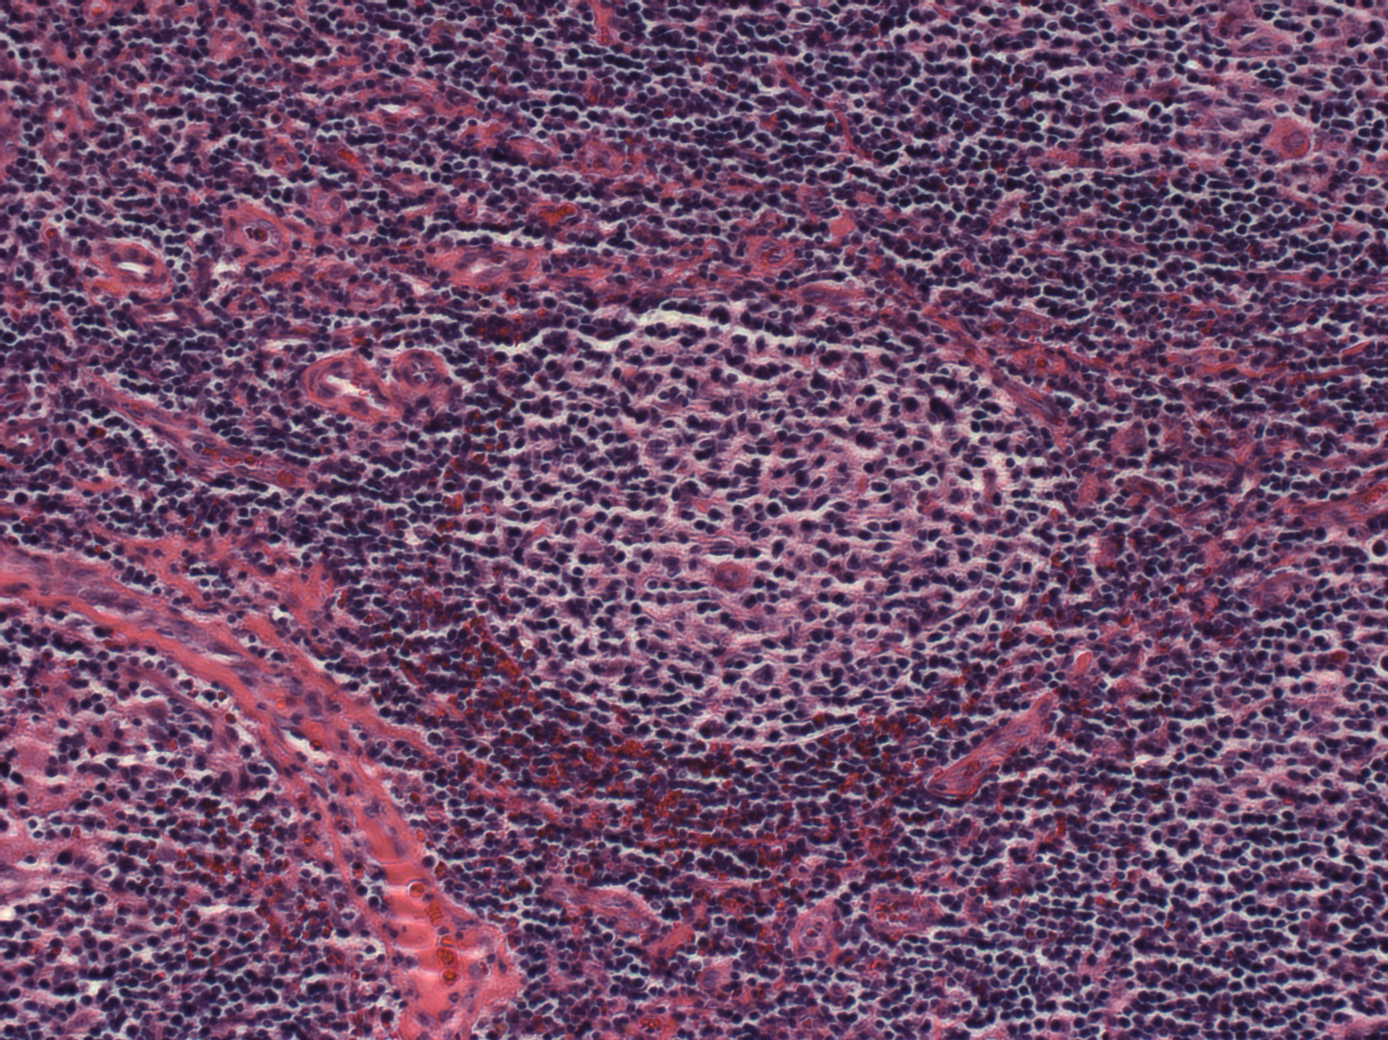

In [30]:
cancer_types, image_dirs, images = load_images('./Images')
print(f'Cancer types are {cancer_types}')
print(f'First image path: {images[0][3]}\nFirst cancer type: {images[0][0]}\nFirst RGB array: {images[0][2]}\nFirst image:\n')
images[0][1]

###Create DataFrame

In [31]:
df = pd.DataFrame(images, columns=['cancer_type', 'image', 'rgb_array', 'image_path'])
df.head(3)

cancer_type  ...                         image_path
0          FL  ...  ./Images/FL/sj-05-5389-R1_008.tif
1          FL  ...  ./Images/FL/sj-05-5389-R1_002.tif
2          FL  ...   ./Images/FL/sj-05-588-R1_001.tif

[3 rows x 4 columns]

# Exploratory Data Analysis

In [32]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [33]:
#@title Default title text
def show_value_counts(series):

    print(f'The value counts are:\n{series.value_counts()}')

    percentages = [i/len(df) for i in series.value_counts().values]
    percentages = [round(i,2) for i in percentages]

    fig, ax = plt.subplots(1,1,figsize=(10,5))

    bar_chart=ax.bar(x=series.value_counts().index, 
                    height=series.value_counts().values)

    # Grabbed from matplotlib documentation:
    # https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
    def autolabel(bar_chart, text_labels):
        for i, bar in enumerate(bar_chart):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    text_labels[i],
                    ha='center', va='bottom')# rotation=0?)
            
    autolabel(bar_chart, percentages)

    plt.title('Count by cancer type with percentages as text')
    plt.show()

############

def get_image_dims(data):

    img_heights = []
    img_widths = []

    # widths and heights if input is pandas series 
    if type(data) is pd.Series:

        for i, _ in enumerate(data):
            img = data.iloc[i]
            width, height = img.size
            img_heights.append(height)
            img_widths.append(width)

    # widths and heights if input is torchvision dataset
    else:

        for i in range(len(data)):
            width, height = data[i][0].shape[2], data[i][0].shape[1]
            img_heights.append(height)
            img_widths.append(width)

    # cast to set to eliminate duplicates
    img_heights = set(img_heights)
    img_widths = set(img_widths)
        
    print('Image heights are: ', set(img_heights))
    print('Image widths are: ', set(img_widths))

    return img_heights, img_widths

############

def get_intensity_range(data):

    maxs = []
    mins = []

    # intesities if input is pandas series
    if type(data) is pd.Series:

        for i, _ in enumerate(data):
            maxs.append(np.amax(data.values[i]))
            mins.append(np.amin(data.values[i]))

    # intensities if input is torchvision dataset
    else:

        for i in range(len(data)):
            maxs.append(torch.max(data[i][0]))
            mins.append(torch.min(data[i][0])) 

    print(f'The highest intesity in the range: {max(maxs)}')
    print(f'The lowest intesity in the range: {min(mins)}')

############

def get_random_image(data, figsize=(30,10)):

    rand_imgs = []
    rand_idxs = []

    if type(data) is pd.Series:
        for i in image_dirs:
            rand_img = random.choice(data.values)
            rand_imgs.append(rand_img)

        fig, axs = plt.subplots(1, len(rand_imgs), figsize=figsize)

        for i, img in enumerate(rand_imgs):
            axs[i].set_title(f'Cancer type: {cancer_types[i]}')
            axs[i].imshow(img)

    else:

        i=0
        for i in range(4):
            
            # get random index and store for later
            data_len = len(data)
            data_len = range(data_len)
            rand_idx = random.choice(data_len)
            rand_idxs.append(rand_idx)
            
            # get image with random index and convert RGB array back to image
            rand_img = data[rand_idx][0]
            rand_img = rand_img.permute(1,2,0)
            rand_imgs.append(rand_img)

            i+=1
            if i==4:
                break

        fig, axs = plt.subplots(1, 4, figsize=figsize)

        for i, img in enumerate(rand_imgs):
            axs[i].set_title(f'Cancer type: {decode_dict[int(data[rand_idxs[i]][1])]}')
            axs[i].imshow(img)

############

def reduce_image_size(series, factor, filter=Image.BICUBIC):

    # Filter can be one of Image.NEAREST, Image.BOX, Image.BILINEAR, 
    # Image.HAMMING, Image.BICUBIC or Image.LANCZOS.
    # Default filter is Image.BICUBIC

    for idx, img in enumerate(series.values):
        (width, height) = (img.width // factor, img.height // factor)
        im = img.resize((width, height), resample=filter)
        series.iloc[idx] = im

###Class distribution

The value counts are:
FL     139
MCL    122
CLL    113
Name: cancer_type, dtype: int64


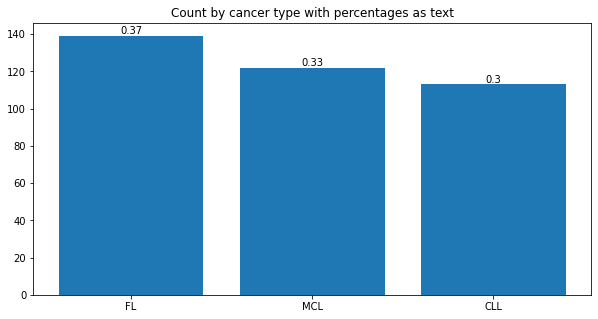

In [34]:
show_value_counts(df['cancer_type'])

###Label Encoding

PyTorch needs the labels to be numerically encoded in order to incorporate them in the dataloader.

In [35]:
encode_dict = {'CLL':0, 'FL':1, 'MCL':2}
decode_dict = {0: 'CLL', 1: 'FL', 2: 'MCL'}
df['cancer_type']=df['cancer_type'].replace(encode_dict)
df['cancer_type'].value_counts()

1    139
2    122
0    113
Name: cancer_type, dtype: int64

###Image size and color intensity

In [36]:
img_heights, img_widths = get_image_dims(df['image'])

Image heights are:  {1040}
Image widths are:  {1388}


Single value sets mean all images with the same height and width.  Let's confirm the pixel color intensity range

In [37]:
get_intensity_range(df['image'])

The highest intesity in the range: 255
The lowest intesity in the range: 2


I think it's safe to say that these RGB color values range from (0,255).  Color scaling later on will reflect this range

###Sample images

Let's look at a random image of each cancer type.

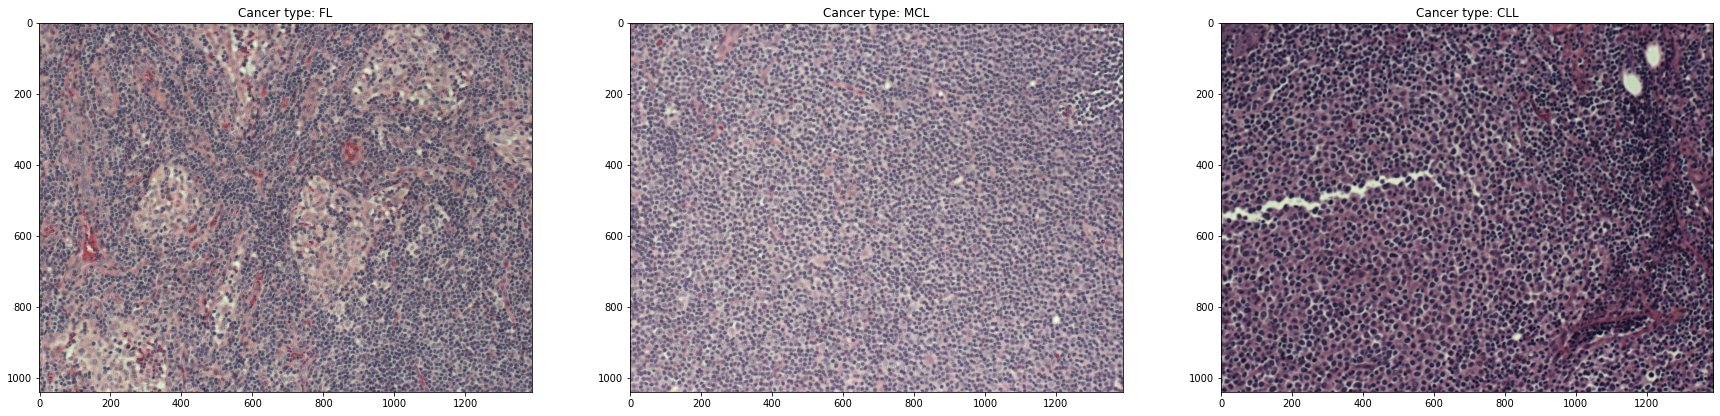

In [38]:
get_random_image(df['image'])

###Image size reduction

In [39]:
reduce_image_size(df['image'], 4)
img_heights, img_widths = get_image_dims(df['image'])
get_intensity_range(df['image'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Image heights are:  {260}
Image widths are:  {347}
The highest intesity in the range: 255
The lowest intesity in the range: 6


### Define some useful constants for later

In [40]:
image_height = img_heights.pop()
image_width = img_widths.pop()
image_size = (image_width, image_height)
image_channels = 3

# Prepare Data

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
def visualize_sets(full_series, train_series, test_series, titles):

    series = [full_series, train_series, test_series]

    percentages = []
    
    for i, series_ in enumerate(series):

        percentage = [j/len(series_) for j in series_.value_counts().values]
        percentage = [round(j,2) for j in percentage]
        percentages.append(percentage)

    fig, ax = plt.subplots(1,len(series),figsize=(20,5))

    dfs=[]

    for i, series_ in enumerate(series):

        df = ax[i].bar(x=series_.value_counts().index, 
                    height=series_.value_counts().values)
        
        dfs.append(df)

    # Grabbed from matplotlib documentation:
    # https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
    def autolabel(bar_charts, text_labels):
        for i, chart in enumerate(bar_charts):
            for j, bar in enumerate(chart):
                height = bar.get_height()
                ax[i].text(bar.get_x() + bar.get_width()/2., height,
                        text_labels[i][j],
                        ha='center', va='bottom')# rotation=0?)
            
    autolabel(dfs, percentages)

    for i, title in enumerate(titles):
        ax[i].set_title(title)
    
    plt.show()

###Train test split

We want to create a holdout test set now, but we don't want to split the target variable yet from the image and its path.  When we move onto data generation, we need to keep the target available, so we will just separate the dataframe as a whole.

In [43]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['cancer_type'], random_state=42) 

In [44]:
print(df_train.shape, df_test.shape)

(299, 4) (75, 4)


Store the training and validation data before splitting for later use in normalization transforms

In [45]:
df_train_and_val = df_train.copy()

###Set visualizing

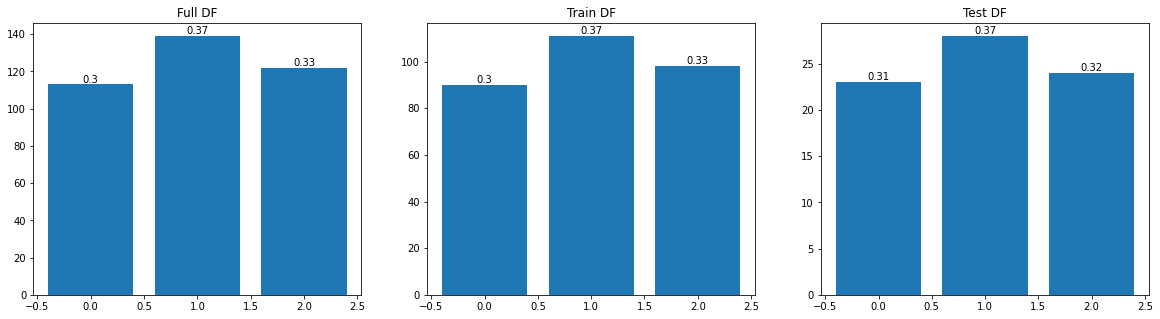

In [46]:
visualize_sets(df['cancer_type'], df_train['cancer_type'], df_test['cancer_type'], ['Full DF', 'Train DF', 'Test DF'])

In [47]:
df_test.head(3)

cancer_type  ...                          image_path
169            2  ...     ./Images/MCL/sj-05-1374_009.tif
360            0  ...  ./Images/CLL/sj-05-3874-R2_007.tif
237            2  ...  ./Images/MCL/sj-04-4967-R2_010.tif

[3 rows x 4 columns]

Let's just reset the index here for clarity.

In [48]:
df_test.reset_index(inplace=True, drop=True)
df_test.head(3)

cancer_type  ...                          image_path
0            2  ...     ./Images/MCL/sj-05-1374_009.tif
1            0  ...  ./Images/CLL/sj-05-3874-R2_007.tif
2            2  ...  ./Images/MCL/sj-04-4967-R2_010.tif

[3 rows x 4 columns]

In [49]:
df_test['cancer_type'].value_counts()

1    28
2    24
0    23
Name: cancer_type, dtype: int64

###Train val split

The data needs to be split again before generation can occur, that was the validation set generated data doesn't get into the training set.

In [50]:
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=42)

In [51]:
df_train.head(3)

cancer_type  ...                          image_path
12             1  ...   ./Images/FL/sj-05-5389-R1_013.tif
349            0  ...     ./Images/CLL/sj-03-5521_008.tif
246            2  ...  ./Images/MCL/sj-05-4179-R1_003.tif

[3 rows x 4 columns]

Again, let's reset our indices.

In [52]:
df_train.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)

# Data Generation

In [53]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

###Device detection

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.backends.cudnn.benchmark = True

cuda


###Dataset and dataloader

Albumentations library

In [55]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

Define dataset class for dataloader to call

In [144]:
class lymphoma_images_dataset(Dataset):

    def __init__(self, type_, images, paths, transform=None):
        self.type_ = type_
        self.images = images
        self.paths = paths
        self.transform = transform
      
    def __len__(self):
        return len(self.type_)
    
    def __getitem__(self, idx):
        
        image = self.images.iloc[idx]
        path = self.paths.iloc[idx]
        label = torch.tensor(int(self.type_.iloc[idx]))

        if self.transform:
            image = self.transform(image)

        return (image, label)

############

def define_dataset(type_series, image_series, path_series, transform, batch_size=1, shuffle=True, num_workers=2):

    data = lymphoma_images_dataset(type_series, image_series, path_series, transform=transform)
    loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    return data, loader

############

def get_normalize_vals(data):

    data_means = []
    data_stds = []

    dataset = lymphoma_images_dataset(data['cancer_type'], data['image'], data['image_path'], transform=transforms.ToTensor())
    dataloader = DataLoader(dataset, batch_size=len(dataset))

    data_ = next(iter(dataloader))

    for i in range(3):
        data_means.append(float(data_[0][i].mean()))
        data_stds.append(float(data_[0][i].std()))

    return data_means, data_stds

############

def albumentations_inputs(data):

    rgb_arrays = data.copy()
    first_image = np.asarray(rgb_arrays.iloc[0])
   
    rgb_arrays = data.iloc[1:].copy()
    second_dict = rgb_arrays.to_dict()
    second_dict = {key:np.asarray(value) for (key, value) in second_dict.items()}

    return first_image, second_dict

In [57]:
# for pre-trained transfer learning networks, we need to use the provided means and standard deviations for normalization
#train_val_means, train_val_stds = get_normalize_vals(df_train_and_val)
#print(f'The RBG image means are: {train_val_means}\nThe RGB image standard deviations are: {train_val_stds}')

In [145]:
# make albumentations compose function happy
first_dict, second_dict = albumentations_inputs(df['rgb_array'])

p = 0.2

tl_means = (0.485, 0.456, 0.406)
tl_stds = (0.229, 0.224, 0.225)

alb_transform_dict = {'train': A.Compose([A.HorizontalFlip(p=p),
                                          A.VerticalFlip(p=p),
                                          A.ColorJitter(p=p),
                                          A.Rotate(limit=10, interpolation=cv2.BORDER_CONSTANT, p=p),
                                          A.RGBShift(p=p),
                                          A.Normalize(mean=tl_means, std=tl_stds),
                                          ToTensorV2()
                      ]),#, additional_targets=second_dict),
                      'valid': A.Compose([A.HorizontalFlip(p=p),
                                          A.VerticalFlip(p=p),
                                          A.ColorJitter(p=p),
                                          A.RGBShift(p=p),
                                          A.Rotate(limit=10, interpolation=cv2.BORDER_CONSTANT, p=p),
                                          A.Normalize(mean=tl_means, std=tl_stds),
                                          ToTensorV2()
                      ]),
                      'test': A.Compose([ToTensorV2()
                      ])
                      }


In [147]:
second = alb_transform_dict['train'](image=first_dict, additional_targets=second_dict)
second['additional_targets'][1]

array([[[174, 153, 166],
        [172, 153, 166],
        [172, 153, 164],
        ...,
        [101,  61,  91],
        [ 89,  56,  89],
        [ 93,  57,  94]],

       [[174, 153, 167],
        [169, 153, 164],
        [175, 153, 161],
        ...,
        [ 86,  61,  93],
        [ 80,  56,  92],
        [ 75,  57,  94]],

       [[180, 159, 168],
        [176, 159, 165],
        [180, 156, 159],
        ...,
        [ 78,  47,  83],
        [ 80,  48,  89],
        [ 79,  53,  95]],

       ...,

       [[ 85,  58, 100],
        [ 91,  58,  99],
        [ 92,  69, 112],
        ...,
        [166, 107, 139],
        [146,  90, 124],
        [118,  73, 110]],

       [[ 93,  65, 103],
        [ 98,  65, 105],
        [ 96,  75, 118],
        ...,
        [185, 117, 142],
        [172, 104, 131],
        [155,  97, 127]],

       [[ 83,  64, 100],
        [101,  64, 100],
        [113,  80, 123],
        ...,
        [182, 118, 137],
        [180, 111, 140],
        [185, 112, 133]]

###Confirm image dimensions and intensities

In [ ]:
img_heights, img_widths = get_image_dims(datasets['train'])

In [ ]:
get_intensity_range(datasets['train'])

###Visualize some generated data

In [ ]:
get_random_image(train_dataset)


# Model Build

In [ ]:
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

###Bespoke model architectures

In [ ]:
class shallow_net(nn.Module):
    # this network will consist of three CRB layers before a fully connected

    def __init__(self):
        super(shallow_net, self).__init__()

        self.conv1_k5 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        # initialize weights?? nn.init.kaiming_uniform_, nn.init.xavier_uniform_
        self.ap = nn.AvgPool2d(2)
        self.fc = nn.Linear(1408, 3)

    
    def forward(self, x):
        x = F.relu(self.ap(self.conv1(x)))
        x = x.view(-1)
        x = self.fc(x)
        return F.log_softmax(x)

class medium_net(shallow_net):
     # this network will consist of five CRB layers before a fully connected
    pass

class deep_net(nn.Module):
    # this network will consist of eight CRB layers before a fully connected
    pass

class very_deep_net(nn.Module):
    # this network will consist of twelve CRB layers before a fully connected
    pass

    # def __init__(self, in_channels):
    #     super(Net, self).__init__()

    #     self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)

    #     self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
    #     self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)

    #     self.branch3x3dbl_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
    #     self.branch3x3dbl_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
    #     self.branch3x3dbl_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)

    #     self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)


    # def forward(self, x):

    #     branch1x1 = self.branch1x1(x)

    #     branch5x5 = self.branch5x5_1(x)
    #     branch5x5 = self.branch5x5_2(branch5x5)

    #     branch3x3 = self.branch3x3dbl_1(x)
    #     branch3x3 = self.branch3x3dbl_2(branch3x3)
    #     branch3x3 = self.branch3x3dbl_3(branch3x3)

    #     branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
    #     branch_pool = self.branch_pool(branch_pool)

    #     outputs = [branch1x1, branch5x5, branch3x3, branch_pool]

    #     return torch.cat(outputs, 1)




###Transfer learning as feature extractor

Since the dataset being classified is significantly different to the ImageNet data that the transfer learning models have been optimized for, these models will only be used as a feature extractor.  This means that the model parameters will be frozen and the only portion that will be trained are the linear layers at the very end of the network.

In [ ]:
import torchvision.models as models

Going to use three different Resnets and Densenets: a shallow, medium, and deep.  Use four VGG models: two shallow and two deep networks, one with and the other without batch normalization.  Also use Inception v3.

In [ ]:
resnet_models = [models.resnet18(pretrained=True), models.resnet50(pretrained=True), models.resnet152(pretrained=True)]
vgg_models = [models.vgg11(pretrained=True), models.vgg11_bn(pretrained=True), models.vgg19(pretrained=True), models.vgg19_bn(pretrained=True)]
densenet_models = [models.densenet121(pretrained=True), models.densenet161(pretrained=True), models.densenet201(pretrained=True)]
inception = models.inception_v3(pretrained=True)

###Determine the fully connected layers that require replacing

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

################

def replace_fc_layers(models, num_classes):

    if models == resnet_models:
        for model in models:
            # freeze all model parameters
            set_parameter_requires_grad(model, True)

            # replace classification layer
            input_features = model.fc.in_features
            model.fc = nn.Linear(input_features, num_classes)
            model.to(device)

    if models == vgg_models:
        for model in models:
            set_parameter_requires_grad(model, True)
            model.classifier[6] = nn.Linear(4096, num_classes)
            model.to(device)
    
    if models == densenet_models:
        for model in models:
            set_parameter_requires_grad(model, True)
            input_features = model.classifier.in_features
            model.classifier = nn.Linear(input_features, num_classes)
            model.to(device)

    if models == inception:
        set_parameter_requires_grad(models, True)
        models.AuxLogits.fc = nn.Linear(768, num_classes)
        models.fc = nn.Linear(2048, num_classes)
        models.to(device)
    
    return models

Take AlexNet as an example

In [ ]:
print(alexnet)

The last output layer (`alexnet.classifier[6]`) inputs 4096 features and outputs 1000.  We need to replace this with a 4096 to 3 fully connected layer.  This process was repeated for all the networks and stored as the function replace_fc_layers at the top of this section

In [ ]:
print(vgg_models[0])

In [ ]:
num_classes = 3

resnet_models = replace_fc_layers(resnet_models, num_classes)
vgg_models = replace_fc_layers(vgg_models, num_classes)
densenet_models = replace_fc_layers(densenet_models, num_classes)
inception = replace_fc_layers(inception, num_classes)

Run a check to make sure layers were written correctly

In [ ]:
print(f'Resnet18:\n{resnet_models[1].fc}\n\nAlexNet:\n{alexnet.classifier[-3:]}\n')

# Train the Model



In [ ]:
from torch.optim.lr_scheduler import StepLR
import time
import copy

In [ ]:
def training_steps(model, criterion, optimizer, scheduler, epochs=25):    
    start = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-'*15)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero out the gradients before training
                optimizer.zero_grad()

                # set gradient calculations ON for training
                with torch.set_grad_enabled(phase == 'train'):
                    if model == inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2

                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} loss: {epoch_loss:.3f}, accuracy: {epoch_acc:.3f}')

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'valid':
                val_acc_history.append(epoch_acc)

        
        print()

    time_elapsed = time.time() - start
    print(f'Training time: {time_elapsed // 60}m {time_elapsed % 60}s')
    print()

    model.load_state_dict(best_model_wts)

    return model, val_acc_history


################

def run_training(models, epochs=25):

    val_acc_histories = {}
    
    for model in models:
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())
        scheduler = StepLR(optimizer, step_size=5, verbose=True)

        model, val_acc_history = training_steps(model, criterion, optimizer, scheduler, epochs=epochs)
        val_acc_histories[model] = val_acc_history

    return models, val_acc_histories

In [ ]:
trained_models, val_acc_history = run_training([inception], epochs=5)